In [1]:
import numpy as np
from matplotlib import pyplot as plt

import mne
from mne import find_events, Epochs, compute_covariance, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import simulate_sparse_stc, simulate_raw, add_noise, add_ecg, add_eog

In [41]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# Load real data as the template
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)
raw.pick_types(eeg=True)
raw.pick_channels(raw.info.ch_names[:16])

Opening raw data file /home/yeison/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_raw.fif, 16 x 166800 (277.7 s), ~2.9 MB, data not loaded>

Reading forward solution from /home/yeison/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


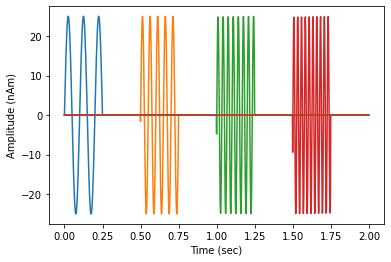

In [46]:
n_dipoles = 4  # number of dipoles to create
epoch_duration = 2.  # duration of each epoch/event
n = 0  # harmonic number
rng = np.random.RandomState(0)  # random state (make reproducible)


def data_fun(times):
    """Generate time-staggered sinusoids at harmonics of 10Hz"""
    global n
    n_samp = len(times)
    window = np.zeros(n_samp)
    start, stop = [int(ii * float(n_samp) / (2 * n_dipoles))
                   for ii in (2 * n, 2 * n + 1)]
    window[start:stop] = 1.
    n += 1
    data = 25e-9 * np.sin(2. * np.pi * 10. * n * times)
    data *= window
    return data


times = raw.times[:int(raw.info['sfreq'] * epoch_duration)]
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
stc = simulate_sparse_stc(src, n_dipoles=n_dipoles, times=times,
                          data_fun=data_fun, random_state=rng)
# look at our source data
fig, ax = plt.subplots(1)
ax.plot(times, 1e9 * stc.data.T)
ax.set(ylabel='Amplitude (nAm)', xlabel='Time (sec)')
mne.viz.utils.plt_show()

Adding noise to 16/16 channels (16 channels in cov)


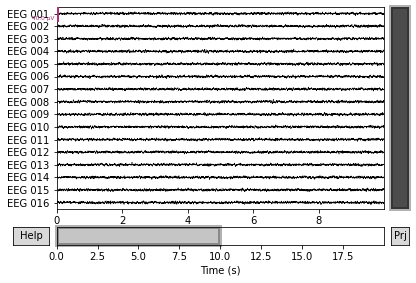

In [47]:
raw_sim = simulate_raw(raw.info, [stc] * 10, forward=fwd, verbose=False)
cov = make_ad_hoc_cov(raw_sim.info)
add_noise(raw_sim, cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng)
# add_ecg(raw_sim, random_state=rng)
# add_eog(raw_sim, random_state=rng)
raw_sim.plot();

In [72]:
x = np.linspace(0, 20, raw_sim._data.shape[1])
xx = np.linspace(0, 20, 20*1000) 
y = []

for channel in raw_sim._data:
    y.append(np.interp(xx, x, channel))
    
y = np.array(y)
y.shape

(16, 20000)

In [73]:
with open('fake_eeg-20s.npy', 'wb') as f:
    np.save(f, y)

In [77]:
import rawutil

def eeg_(values): return [rawutil.pack('>u', v // 24) for v in values.tolist()]

In [99]:
eeg_data = np.array([rawutil.unpack('>u', bytes(ch))[0] for ch in eeg.reshape(-1, 3)]).reshape(-1, 8) * 24

AttributeError: 'list' object has no attribute 'reshape'

In [98]:
eeg = list(b''.join(eeg_(np.array([400, 5, 6]))))
eeg

[0, 0, 16, 0, 0, 0, 0, 0, 0]